In [1]:
import warnings
warnings.filterwarnings('ignore')

import cmasher as cmr
import janitor
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme(
    context="notebook", font_scale=1.5, style="whitegrid", palette="gray"
)  #  Darkgrid Whitegrid Dark White Ticks

from utilities import save_mpl_fig

In [2]:
df_dl = (
    pd.read_csv("../input/pkg_pypi_downloads.csv")
    .assign(date=lambda df: pd.to_datetime(df["date"]))
)
df_dl

,pkg,date,download_count,tt_downloads,treated,boughtstars,treated2,_merge
0,a-pandas-ex-df2htmlstring,2023-04-25,0,0,0,0,0,left_only
1,a-pandas-ex-df2htmlstring,2023-04-26,0,0,0,0,0,left_only
2,a-pandas-ex-df2htmlstring,2023-04-27,0,0,0,0,0,left_only
3,a-pandas-ex-df2htmlstring,2023-04-28,7,7,0,0,0,left_only
4,a-pandas-ex-df2htmlstring,2023-04-29,7,14,0,0,0,left_only
...,...,...,...,...,...,...,...,...
29229,zoomaker,2023-06-06,0,135,0,0,0,left_only
29230,zoomaker,2023-06-07,1,136,0,0,0,left_only
29231,zoomaker,2023-06-08,1,137,0,0,0,left_only
29232,zoomaker,2023-06-09,0,137,0,0,0,left_only


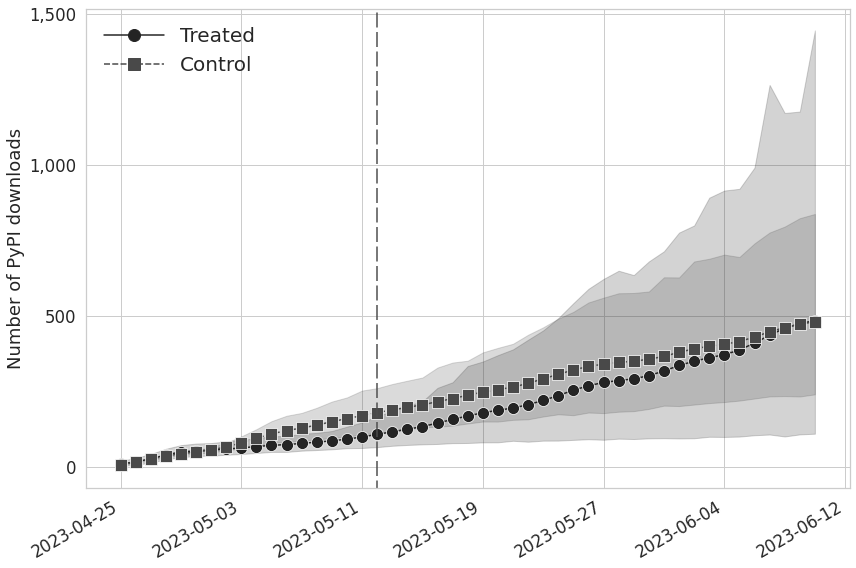

In [3]:
# Treated vs control
_, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(
    data=df_dl,
    x="date",
    y="tt_downloads",
    markersize=12,
    hue="treated",
    style="treated",
    hue_order=[1, 0],
    style_order=[1, 0],
    markers=["o", "s"],
    #     err_style="bars",
    ax=ax,
)

# Set the locator and formatter for the x-axis
myFmt = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(myFmt)

# Specify the desired number of x-axis tickers
ax.xaxis.set_major_locator(plt.MaxNLocator(7))

plt.xticks(rotation=30, ha="right")

# Add a vertical line to annotate a time period
annotate_date = pd.to_datetime("2023-05-12")  # Specify the date to annotate
plt.axvline(x=annotate_date, color=".3", linestyle=(5, (10, 3)))

# # Annotate a text on the plot
# annotate_date = pd.to_datetime('2023-05-15')  # Specify the date to annotate
# annotate_text = 'Annotated Text'  # Specify the text to annotate
# plt.annotate(annotate_text, xy=(annotate_date, 30), xytext=(10, 10),
#              textcoords='offset points', arrowprops=dict(arrowstyle='->'))

plt.locator_params(axis='y', nbins=6)
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.set_ylabel("Number of PyPI downloads")
ax.set_xlabel("")

# Legend
# get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# specify order of items in legend
order = [0, 1]
labels = ["Treated", "Control"]
ax.legend(
    labels=[labels[idx] for idx in order],
    handles=[handles[idx] for idx in order],
    title="",
    loc="upper left",
    fontsize=20,
    markerscale=2,
    markerfirst=True,
    frameon=False,
    handlelength=3,
)

plt.tight_layout()

save_mpl_fig("../output/timeseries-downloads-treated-01")

/home/lsys/social_proof_stars/venv/lib/python3.10/site-packages/cmasher/utils.py:983: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mplcm.get_cmap(cmap)
/home/lsys/social_proof_stars/venv/lib/python3.10/site-packages/cmasher/utils.py:1331: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mplcm.get_cmap(cmap)


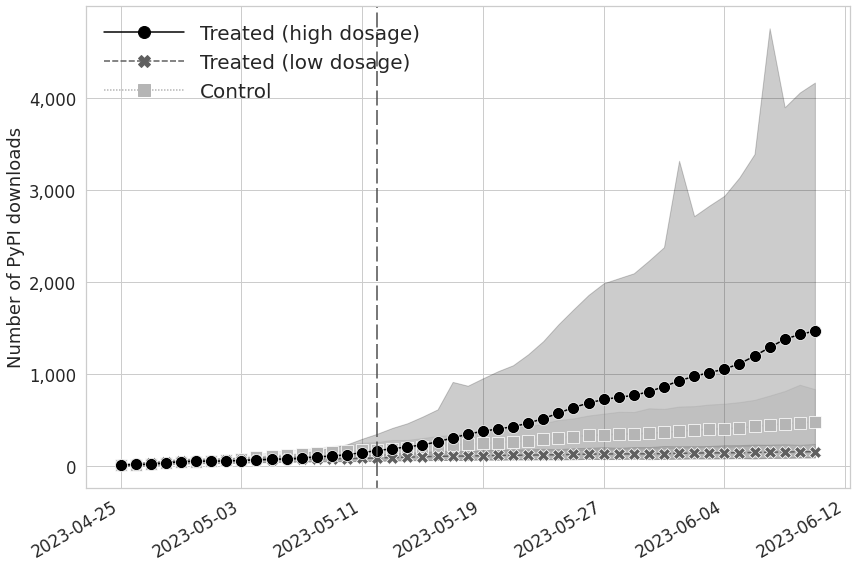

In [4]:
# Treated (by dosage) vs control
_, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(
    data=df_dl,
    x="date",
    y="tt_downloads",
    markersize=12,
    hue="treated2",
    style="treated2",
    hue_order=[2, 1, 0],
    style_order=[2, 1, 0],
    markers=["o", "X", "s"],
    palette=cmr.get_sub_cmap("Greys", 0.4, 1),
    #     err_style="bars",
    ax=ax,
)

# Set the locator and formatter for the x-axis
myFmt = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(myFmt)

# Specify the desired number of x-axis tickers
ax.xaxis.set_major_locator(plt.MaxNLocator(7))

plt.xticks(rotation=30, ha="right")

# Add a vertical line to annotate a time period
annotate_date = pd.to_datetime("2023-05-12")  # Specify the date to annotate
plt.axvline(x=annotate_date, color=".3", linestyle=(5, (10, 3)))

# # Annotate a text on the plot
# annotate_date = pd.to_datetime('2023-05-15')  # Specify the date to annotate
# annotate_text = 'Annotated Text'  # Specify the text to annotate
# plt.annotate(annotate_text, xy=(annotate_date, 30), xytext=(10, 10),
#              textcoords='offset points', arrowprops=dict(arrowstyle='->'))

# ax.set_yticks(range(0, 400, 50))
plt.locator_params(axis='y', nbins=6)
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.set_ylabel("Number of PyPI downloads")
ax.set_xlabel("")

# Legend
# get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# specify order of items in legend
order = [2, 1, 0]

# add legend to plot
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])

labels = ["Control", "Treated (low dosage)", "Treated (high dosage)"]
ax.legend(
    labels=[labels[idx] for idx in order],
    handles=[handles[idx] for idx in order],
    title="",
    loc="upper left",
    fontsize=20,
    markerscale=2,
    markerfirst=True,
    frameon=False,
    handlelength=4,
)

plt.tight_layout()

save_mpl_fig("../output/timeseries-downloads-treated-012")